# Project Summary

## Problem Statement

Dynamic Contrast-Enhanced MRI (DCE-MRI) is a critical imaging technique used to assess tissue perfusion and vascular properties by tracking the distribution of a contrast agent over time. However, a significant challenge in DCE-MRI analysis is accurately determining the Arterial Input Function (AIF), which describes the concentration of the contrast agent in the blood plasma over time. The AIF is essential for calculating pharmacokinetic (PK) parameters such as the volume transfer constant (K<sup>trans</sup>), the exchange rate constant (k<sub>ep</sub>), and the plasma volume fraction (v<sub>p</sub>).

## Importance of Solving the Problem

Accurate estimation of the AIF is crucial because it directly impacts the reliability of PK parameters, which are used for diagnosing and monitoring various diseases, including cancer. Traditional methods of AIF measurement often suffer from noise and variability, making them unreliable. Therefore, improving the accuracy and robustness of AIF and PK parameter estimation can significantly enhance the diagnostic power of DCE-MRI, leading to better patient outcomes.

### PK Parameters Explained
- **K<sup>trans</sup>**: Volume transfer constant, indicating the rate at which the contrast agent moves from blood plasma into the extravascular extracellular space.
- **k<sub>ep</sub>**: Exchange rate constant, representing the rate at which the contrast agent returns from the extravascular extracellular space to the plasma.
- **v<sub>p</sub>**: Plasma volume fraction, indicating the fraction of tissue volume occupied by blood plasma.

## Machine Learning Approach

This project proposes a machine learning (ML) approach to estimate the AIF and PK parameters directly from individual contrast time curves obtained from DCE-MRI. By focusing on contrast time curves, which are image-agnostic, the method aims to simplify the estimation process and reduce dependencies on specific imaging parameters.

### Detailed Methodology

1. **Initial Input**: The user provides the neural network with a small number of contrast time curves (e.g., 4).
2. **First Pass**: The neural network processes these curves and outputs the PK parameters for only the first contrast time curve.
3. **Iterative Processing**: The user then keeps the first contrast time curve fixed and swaps out the other time curves with new ones. The neural network is run again with this new set of curves.
4. **Repetition**: This process is repeated multiple times, each time keeping the first contrast time curve fixed and changing the others.
5. **Averaging Results**: After several iterations, the average of the PK parameters obtained from all runs is calculated. This average is used as the final result.

### Training the Neural Network

The neural network is trained with this iterative approach in mind. During training, the loss function is computed as the average of the errors over several runs, where the last few contrast time curves are swapped out in each run. This ensures that the neural network is optimized to produce correct results on average, tolerating some variance in the individual outputs.

### Comparison with Simple Neural Network

To evaluate the effectiveness of this averaging approach, it will be compared to a simple neural network that outputs PK parameters without any averaging. The performance of both approaches will be assessed to determine if averaging the results improves the accuracy and robustness of the PK parameter estimation.

### Advantages of the Proposed Approach

1. **Simplicity**: The use of individual contrast time curves avoids the complexities associated with full image data, making the approach more straightforward and potentially more robust to noise and variability.
2. **Generalizability**: Since the method relies on contrast time curves rather than full images, it can be more easily generalized across different imaging setups and patient populations.
3. **Robustness**: By averaging the results from multiple runs, the approach ensures that the neural network's output is robust to variability and noise in the input data.

## Comparison with Other Approaches

In contrast to the proposed method, several approaches in the literature utilize the entire k-space dataset (raw MRI data) as input to neural networks for PK parameter estimation. These methods often involve complex preprocessing and significant computational resources. Examples of such approaches include:

- **Unpaired Deep Learning for PK Parameter Estimation**: This method uses CycleGANs to estimate PK parameters from k-space data without paired training samples.
- **Deep CNN with Forward Physical Model Loss**: This technique employs a deep convolutional neural network (CNN) to infer PK parameters directly from k-space data, incorporating a forward physical model loss to enhance accuracy.

By focusing on contrast time curves, the proposed ML approach aims to provide a more efficient and potentially more accurate alternative for AIF and PK parameter estimation in DCE-MRI.


## Importing Modules and Mounting Google Drive

This section imports the required modules for the project and mounts Google Drive to access project files. Remember to change the directory path as needed.

- **Imports**: Includes essential libraries such as `numpy`, `torch`, `scipy`, `opencv`, `matplotlib`, and others.
- **Mount Google Drive**: Uses `drive.mount('/content/drive')` to mount Google Drive.
- **Change Directory**: Sets the working directory to the specified project folder. Update the path as necessary.



In [20]:
import time
import os
import glob
import math
import numpy as np
import torch
import scipy.io as sio
import cv2
import time
from scipy.optimize import least_squares


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.distributions import *


#import matplotlib.pyplot as plt
import matplotlib.pylab as plt

from IPython.display import display, clear_output

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Projects/ML_AIF

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Projects/ML_AIF


## Loading and Formatting Dataset

This section defines the path to the dataset, loads the `.mat` file, and reshapes the data into the correct format.

- **Define Path**: Sets the path to the dataset as a string.
- **Load Dataset**: Uses `scipy.io.loadmat` to load the `.mat` file.
- **Extract and Reshape Data**: Extracts the data and reshapes it into a one-dimensional tensor.

Remember to update the path to the dataset as necessary.


In [21]:
# define path to the dataset as a string...
path_to_aif = "AIF.mat"

aif_dictionary = sio.loadmat(path_to_aif)
# print("Number of elements in z_dictionary: {}".format(len(z_dictionary['y'])))

aif_matrix = aif_dictionary['AIF'] # [100x4x2]
print("Shape of aif: ", aif_matrix.shape)

avgAIF = aif_matrix.reshape(500,)
avgAIF = torch.from_numpy(avgAIF)

Shape of aif:  (1, 500)


### Function: `gen_AIF`
This function generates an Arterial Input Function (AIF) based on a combination of Gaussian and sigmoid functions.

- **Parameters:**
  - `t` (tensor): Time points over which the AIF is computed.
  - `alpha`, `beta`, `t3` (float): Parameters for the sigmoid function.
  - `A1`, `A2`, `T1`, `T2`, `sig1`, `sig2` (float): Parameters for the two Gaussian functions.

- **Returns:**
  - `AIF` (tensor): The generated AIF reshaped to a column vector.

- **Description:**
  - The function initializes the AIF as a zero tensor.
  - It then adds two Gaussian functions to the AIF, followed by a sigmoid function to complete the AIF modeling.
  - The AIF is reshaped to a column vector before returning.

### Function: `gen_train_data`
This function generates synthetic training data using random parameters and the generated AIF.

- **Parameters:**
  - `M` (int): The number of data points to generate.

- **Returns:**
  - `y` (tensor): A tensor containing the ground truth values for `kep`, `vp/kt`, and the normalized AIF.
  - `x` (tensor): A tensor containing the synthesized signals.

- **Description:**
  - The function generates random values for `kt`, `kep`, and `vp`.
  - It creates time points `t` and generates an AIF using the `gen_AIF` function.
  - The AIF is padded to 1024 points and used to compute the synthetic signals `x` via FFT.
  - The `y` tensor contains the `kep`, `vp/kt`, and the normalized AIF for the first data point.
  - The `x` tensor contains the FFT-based synthetic signals for all data points.

### Function: `gen_batch`
This function generates a batch of training data by repeatedly calling `gen_train_data`.

- **Parameters:**
  - `N` (int): The number of batches to generate.
  - `M` (int): The number of data points in each batch.

- **Returns:**
  - `y` (tensor): A stacked tensor of `y` values from each batch.
  - `x` (tensor): A stacked tensor of `x` values from each batch.

- **Description:**
  - The function initializes empty lists for `y` and `x`.
  - It loops `N` times, generating `y` and `x` for each batch using `gen_train_data`.
  - The results are stacked into tensors and returned.

In [22]:
def gen_AIF(t, alpha, beta, t3, A1, A2, T1, T2, sig1, sig2):
    AIF = torch.zeros(len(t),)

    # First the two gaussians
    dist = Normal(T1,sig1)
    AIF += A1*torch.exp(dist.log_prob(t))
    dist = Normal(T2,sig2)
    AIF += A2*torch.exp(dist.log_prob(t))

    # Then the sigmoid
    AIF += alpha*torch.exp(-beta*(t-t3))*t
    return AIF.reshape(-1,1)


def gen_train_data(M):
    kt = (10-0.01)*torch.rand(M,) + 0.01
    kep = (4-0.01)*torch.rand(M,) + 0.01
    vp = torch.rand(M,)



    t = torch.linspace(0,120, 500)
    t /= 60
    alpha = 0.1
    beta = 1
    t3 = 0.05

    A1 = 0.02
    A2 = 0.003

    T1 = 0.05
    T2 = 0.3
    sig1 = 0.06
    sig2 = 0.06

    AIF = gen_AIF(t,alpha,beta,t3, A1, A2, T1, T2, sig1, sig2)
    AIFpad =  torch.zeros(1024,M)
    AIFpad[0:500,:] = AIF
    hpad = torch.zeros(AIFpad.shape)
    del_t = t[2]-t[1]

    for n in range(M):
        h = torch.exp(-kep[n]*t)*kt[n]*del_t
        h[0] += vp[n]
        hpad[0:500,n] = h.reshape(-1,)



    x = torch.abs(torch.fft.ifft(torch.fft.fft(AIFpad, dim=0)*torch.fft.fft(hpad, dim=0), dim=0))
    x = x[0:500,:]
    y = torch.zeros((502,))
    y[0] = kep[0]
    y[1] = vp[0]/kt[0]
    AIF = AIF[:,0]
    AIF = AIF / torch.mean(AIF)
    y[2:502] = AIF
    return y, x.T


def gen_batch(N,M):
    y = []
    x = []

    for n in range(0,N):
        yt, xt = gen_train_data(M)
        y.append(yt)
        x.append(xt)
    y = torch.stack(y)
    x = torch.stack(x)
    return y.reshape(N,1,502), x


## Data Preparation for Training and Evaluation

In this section, the training and evaluation data are generated using the previously defined functions. The generated data will be used to train and evaluate the neural network model.

### Generating Data

The `gen_batch` function is used to generate a batch of data consisting of 500 samples, each with 4 contrast time curves.

- **y_matrix**: This matrix contains the PK parameters and normalized AIF for each sample.
- **x_matrix**: This matrix contains the generated contrast time curves for each sample.

In [23]:
y_matrix, x_matrix = gen_batch(500,4)

print(torch.max(x_matrix))
print(y_matrix.shape)
print(x_matrix.shape)

tensor(0.724)
torch.Size([500, 1, 502])
torch.Size([500, 4, 500])


## Data Preparation and Splitting

In this section, the data is prepared for training by transferring it to the GPU and splitting it into training, validation, and testing sets.

### GPU Utilization

- **Device Setup**: The computation device is set to the first available GPU (`cuda:0`) to leverage faster processing capabilities.

### Data Splitting

The dataset is divided into three subsets: training, validation, and testing. This is crucial for training the model, tuning hyperparameters, and evaluating its performance.

- **Training Set**: 70% of the data is used for training the neural network.
- **Validation Set**: 15% of the data is used for validating the model during training to tune hyperparameters and prevent overfitting.
- **Testing Set**: The remaining 15% of the data is used for testing the final model's performance.

### Input and Output Arrays

- **Input Arrays**: These contain the generated contrast time curves.
  - `train_input_array`: Training inputs.
  - `val_input_array`: Validation inputs.
  - `test_input_array`: Testing inputs.

- **Output Arrays**: These contain the corresponding PK parameters and normalized AIFs.
  - `train_output_array`: Training outputs.
  - `val_output_array`: Validation outputs.
  - `test_output_array`: Testing outputs.

By preparing and splitting the data into these subsets, we ensure a robust framework for training, validating, and testing the neural network model.


In [24]:
# put things on GPU...
device = torch.device("cuda:0")

# Split into training, validation, testing sets
num_samples = len(x_matrix)
train_split = math.floor(0.70*num_samples)
val_split = math.floor(train_split+0.15*num_samples)

# These are the X's (input)
train_input_array = x_matrix[0:train_split]
val_input_array = x_matrix[train_split:val_split]
test_input_array = x_matrix[val_split:]

# These are the z's (output). Would need to couple Xs (input) and Zs (ground truth)
train_output_array = y_matrix[0:train_split]
val_output_array = y_matrix[train_split:val_split]
test_output_array = y_matrix[val_split:]

print("Shape of train input and train output arrays: {} {}".format(train_input_array.shape, train_output_array.shape))


Shape of train input and train output arrays: torch.Size([350, 4, 500]) torch.Size([350, 1, 502])


## Dataset Classes

In this section, custom dataset classes are defined for handling the training and testing portions of the data. These classes will be used to facilitate the loading and processing of data during model training and evaluation.

### Training Dataset Class

**Class**: `TrainDceDataset`

- **Purpose**: Manages the training data, providing methods to access input-output pairs.
- **Attributes**:
  - `self.x`: Contains the training input data (`train_input_array`).
  - `self.y`: Contains the training output data (`train_output_array`).
- **Methods**:
  - `__len__()`: Returns the total number of samples in the training dataset.
  - `__getitem__(index)`: Returns the input-output pair at the specified index. The input (`x`) is a 4x500 tensor, and the output (`y`) is a tensor containing PK parameters and normalized AIF.

### Testing Dataset Class

**Class**: `TestDceDataset`

- **Purpose**: Manages the testing data, providing methods to access input-output pairs.
- **Attributes**:
  - `self.x`: Contains the testing input data (`test_input_array`).
  - `self.y`: Contains the testing output data (`test_output_array`).
- **Methods**:
  - `__len__()`: Returns the total number of samples in the testing dataset.
  - `__getitem__(index)`: Returns the input-output pair at the specified index. The input (`x`) is a 4x500 tensor, and the output (`y`) is a tensor containing PK parameters and normalized AIF.

These dataset classes will be used with PyTorch's DataLoader to efficiently load and batch the data during the training and evaluation of the neural network model.


In [25]:
# Dataset class for the training portion of data
class TrainDceDataset(Dataset):
    def __init__(self):
        self.x = train_input_array
        self.y = train_output_array

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        # returns ith sample as a tuple (x, z), where x is [4x500], and z is [4x2]
        return self.x[index], self.y[index]

# Dataset class for testing portion of data
class TestDceDataset(Dataset):
    def __init__(self):
        self.x = test_input_array
        self.y = test_output_array

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        # returns ith sample as a tuple (x, z)
        return self.x[index], self.y[index]

In [26]:
# piece of code to test the sampling/iteration through dataset
train_dce_dataset = TrainDceDataset()
for i in range(0, 2):
    sample = train_dce_dataset[i]
    print(sample[1].shape)

torch.Size([1, 502])
torch.Size([1, 502])


## Data Loading and Batching

In this section, the dataset classes are instantiated and PyTorch DataLoaders are defined for shuffling and batching the data during training and evaluation.

### Dataset Instantiation

- **Training Dataset**: An instance of `TrainDceDataset` is created to manage the training data.
- **Testing Dataset**: An instance of `TestDceDataset` is created to manage the testing data.

### DataLoaders

DataLoaders are created for both the training and testing datasets. DataLoaders facilitate efficient data loading, shuffling, and batching, which are essential for training neural networks.

- **Training DataLoader**:
  - **Instance**: `train_loader`
  - **Batch Size**: 5
  - **Purpose**: Provides shuffled batches of training data for model training.

- **Testing DataLoader**:
  - **Instance**: `test_loader`
  - **Batch Size**: 50
  - **Purpose**: Provides batches of testing data for model evaluation. Since there are only 15 test samples, any batch size less than 15 can be used.

These DataLoaders ensure that the data is efficiently loaded and processed in batches during the training and evaluation phases of the neural network.


In [27]:
# convert data sourced from path into a dataset; and perform any transforms from torchvision as needed...
train_dce_dataset = TrainDceDataset()
test_dce_dataset = TestDceDataset()


# define the dataloader needed for shuffling/sampling batches to train on
train_loader = torch.utils.data.DataLoader(train_dce_dataset, batch_size=5) # !!! use default sampler for now !!!
test_loader = torch.utils.data.DataLoader(test_dce_dataset, batch_size=50) # can use any number < 15 for batch size, there's only 15 test samples

# demonstrating it samples correctly
for x, z in train_loader:
    print(x.shape)
    print(z.shape)
    break

torch.Size([5, 4, 500])
torch.Size([5, 1, 502])


### Class: `FCNN`
This class implements a fully connected neural network (FCNN) with multiple hidden layers and an output layer.

- **Initialization (`__init__`):**
  - `layer_sizes` (list): A list defining the sizes of each layer in the network.
  - The network is constructed using a list of linear layers (`nn.Linear`) and activation functions (`nn.LeakyReLU`).
  - The weights are initialized using Xavier initialization.

- **Forward Pass (`forward`):**
  - The input `x` passes through all layers sequentially, applying each layer's linear transformation followed by a non-linear activation.
  - The final output is the absolute value of the last layer's output.

### Class: `FCNN_norm`
This class extends the `FCNN` to normalize its output.

- **Initialization (`__init__`):**
  - Similar to `FCNN`, but includes an additional normalization step in the forward pass.

- **Forward Pass (`forward`):**
  - After passing through the layers, the output is normalized by dividing each element by the mean of its absolute value across the last dimension.

### Class: `CNN`
This class implements a simple convolutional neural network (CNN) for 1D input data.

- **Initialization (`__init__`):**
  - Initializes four convolutional layers (`nn.Conv1d`) and one fully connected layer (`nn.Linear`).
  - Uses Leaky ReLU activations after each convolution.

- **Forward Pass (`forward`):**
  - The input is reshaped and passed through the convolutional layers sequentially, followed by a fully connected layer.
  - The output is the absolute value of the final output.

### Class: `CNN2`
This class is a variation of `CNN` with a different output size in the final fully connected layer.

- **Initialization (`__init__`):**
  - Similar to `CNN`, but the final fully connected layer has a different output size (2 instead of 500).

- **Forward Pass (`forward`):**
  - Similar to `CNN`, but produces a 2-element output vector.

### Class: `ResidualBlock`
This class implements a residual block used in ResNet architectures.

- **Initialization (`__init__`):**
  - Initializes two convolutional layers (`nn.Conv1d`) with batch normalization (`nn.BatchNorm1d`).
  - Includes a downsampling layer if the input and output sizes differ.

- **Forward Pass (`forward`):**
  - The input is passed through the two convolutional layers and then added to the residual (input) connection.
  - The output is passed through a ReLU activation function.

### Class: `ResNet`
This class implements a ResNet architecture using the `ResidualBlock`.

- **Initialization (`__init__`):**
  - Initializes a series of layers using the `ResidualBlock`, followed by a fully connected layer.
  - Includes a max-pooling layer and an average-pooling layer.

- **Helper Method (`_make_layer`):**
  - Constructs a sequence of residual blocks, adjusting the number of filters and stride as necessary.

- **Forward Pass (`forward`):**
  - The input is reshaped and passed through the convolutional layers, residual blocks, and pooling layers.
  - The output is passed through a fully connected layer for final classification.

In [28]:
class FCNN(nn.Module):
    # pass through two hidden layers and an output layer
    def __init__(self, layer_sizes):
        super(FCNN, self).__init__()
        self.fcs = nn.ModuleList()
        self.layers = nn.ModuleList()
        #self.dropout = nn.Dropout(0.075)
        for n in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[n], layer_sizes[n+1]))
            self.layers.append(nn.LeakyReLU())
        self.layers.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # network takes input of shape [16x2000], generates [16x8] output
        # out = torch.flatten(x, start_dim=1, end_dim=-1) don't need this because moved flatten outside
        for layer in self.layers:
            x = layer(x)
           #x = self.dropout(x)
        return torch.abs(x)

class FCNN_norm(nn.Module):
    # pass through two hidden layers and an output layer
    def __init__(self, layer_sizes):
        super(FCNN_norm, self).__init__()
        self.fcs = nn.ModuleList()
        self.layers = nn.ModuleList()
        for n in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[n], layer_sizes[n+1]))
            self.layers.append(nn.LeakyReLU())
        self.layers.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # network takes input of shape [16x2000], generates [16x8] output
        # out = torch.flatten(x, start_dim=1, end_dim=-1) don't need this because moved flatten outside
        for layer in self.layers:
            x = layer(x)
        m = torch.mean(torch.abs(x), -1)
        m = m.repeat(x.shape[1],1).T
        y = torch.abs(x)/m
        return y

class CNN(nn.Module):
    # pass through two hidden layers and an output layer
    def __init__(self,batch_size, in_channels, hidden_channels_1, hidden_channels_2, out_channels):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels, hidden_channels_1, 10, stride = 4)
        self.relu1 = nn.LeakyReLU()
        self.cnn2 = nn.Conv1d(hidden_channels_1, hidden_channels_2, 5, stride = 4)
        self.relu2 = nn.LeakyReLU()
        self.cnn3 = nn.Conv1d(hidden_channels_2, out_channels, 5, stride = 4)
        self.cnn4 = nn.Conv1d(out_channels, in_channels, 10, stride = 4)
        self.batch_size = batch_size
        self.in_channels =  in_channels
        self.fc = nn.Linear(6, 500)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size,self.in_channels,-1)
        # network takes input of shape [16x2000], generates [16x8] output
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.cnn3(out) # this is [16x8]
        out = self.relu1(out)
        out = self.cnn4(out)
        out = out.reshape(batch_size,-1)
        out = self.fc(out)
        return torch.abs(out)
class CNN2(nn.Module):
    # pass through two hidden layers and an output layer
    def __init__(self,batch_size, in_channels, hidden_channels_1, hidden_channels_2, out_channels):
        super(CNN2, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels, hidden_channels_1, 10, stride = 4)
        self.relu1 = nn.LeakyReLU()
        self.cnn2 = nn.Conv1d(hidden_channels_1, hidden_channels_2, 5, stride = 4)
        self.relu2 = nn.LeakyReLU()
        self.cnn3 = nn.Conv1d(hidden_channels_2, out_channels, 5, stride = 4)
        self.cnn4 = nn.Conv1d(out_channels, in_channels, 10, stride = 4)
        self.batch_size = batch_size
        self.in_channels =  in_channels
        self.fc = nn.Linear(6, 2)

    def forward(self, x):
        x = x.reshape(batch_size,self.in_channels,-1)
        # network takes input of shape [16x2000], generates [16x8] output
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.cnn3(out) # this is [16x8]
        out = self.relu1(out)
        out = self.cnn4(out)
        out = out.reshape(batch_size,-1)
        out = self.fc(out)
        return torch.abs(out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm1d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm1d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet, self).__init__()
        self.inplanes = 1
        self.conv1 = nn.Sequential(
                        nn.Conv1d(1, 2, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm1d(2),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 2, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 4, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 8, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 16, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(570, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm1d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size,1,-1)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.reshape(batch_size,-1)
        x = self.fc(x)

        return x


### Function: `train_fcnn`
This function trains a fully connected neural network (FCNN) using the Mean Squared Error (MSE) loss function and an Adam optimizer.

- **Parameters:**
  - `model` (nn.Module): The FCNN model to be trained.
  - `optimizer` (torch.optim.Optimizer): The optimizer used for updating model weights.

- **Returns:**
  - `train_loss_history` (list): A list of loss values recorded during training.
  - `iters` (list): A list of iteration counts corresponding to each recorded loss value.

- **Training Loop:**
  - The function trains the model for 300 epochs, iterating over the training data provided by `train_loader`.
  - Inputs `x` and targets `z` are flattened and moved to the specified device (e.g., GPU).
  - The model's output is compared to the target using MSE loss.
  - The loss is backpropagated, and the optimizer updates the model's weights.
  - Loss values and iteration counts are recorded for later analysis.

- **Visualization:**
  - After each epoch, the model's output for a single batch is plotted against the ground truth to visualize the learning process.
  - The plot shows the learned Arterial Input Function (AIF) compared to the true AIF, with the loss value displayed in the plot's title.

- **Usage:**
  - The function is called after initializing the model, optimizer, and plotting environment.
  - It returns the training loss history and the iteration numbers for further analysis or plotting.



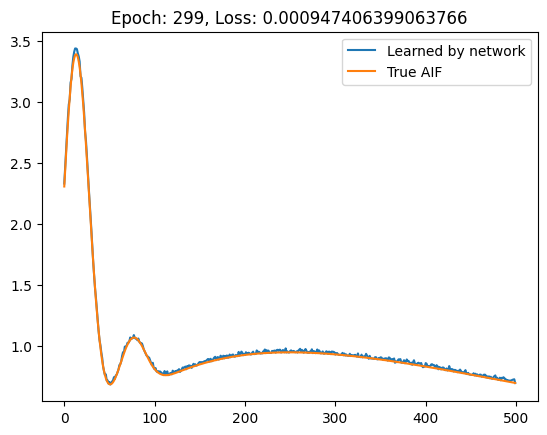

In [29]:
def train_fcnn(model, optimizer):
  loss_fn = nn.MSELoss()

  iters, train_loss_history = [], []
  model.train()

  epochs = 300
  n = 0

  for epoch in range(epochs):
      for x, z in train_loader:
          x = torch.flatten(x, start_dim=1, end_dim=-1)
          z = torch.flatten(z, start_dim=1, end_dim=-1)

          x = x.to(device)
          z = z.to(device)

          x = x.float()
          z = z.float()

          optimizer.zero_grad()
          out = model(x)
          loss = loss_fn(out,z)

          loss.backward()
          optimizer.step()

          train_loss_history.append(loss.item())
          iters.append(n)


          n += 1

      if epoch%1==0:
          test = out.cpu().detach().numpy()
          truth = z.cpu().detach().numpy()
          ax.cla()
          ax.plot(test[0,2:].T, label = "Learned by network")
          ax.plot(truth[0,2:].T, label = "True AIF")
          ttl = "Epoch: " + str(epoch) + ", Loss: " + str(loss.item())
          ax.set_title(ttl)
          ax.legend()
          display(fig)

          clear_output(wait = True)
          plt.pause(0.01)


  return train_loss_history, iters
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

layer_sizes = [2000,1500,700,502]
model = FCNN([2000,1500,700,502])
model.to(device)
optimizer = optim.Adam(model.parameters(), 0.0001)
train_loss_history, iters = train_fcnn(model, optimizer)

### Class: `PercentageErrorStats`
This class calculates the mean and variance of percentage errors between predicted and target values.

- **Initialization (`__init__`):**
  - The class is initialized without any specific parameters.

- **Forward Pass (`forward`):**
  - **Parameters:**
    - `input` (tensor): The predicted values.
    - `target` (tensor): The ground truth values.
  - **Returns:**
    - `mean_percentage_error` (tensor): The mean percentage error across all elements.
    - `variance_percentage_error` (tensor): The variance of the percentage errors.
  - **Functionality:**
    - The percentage error is calculated as the absolute difference between `input` and `target`, divided by `target`, and then multiplied by 100.
    - The mean and variance of these percentage errors are computed and returned.

### Function: `evaluate_fcnn`
This function evaluates a fully connected neural network (FCNN) on a test dataset using the `PercentageErrorStats` loss function.

- **Parameters:**
  - `model` (nn.Module): The FCNN model to be evaluated.

- **Returns:**
  - `mean_err_AIF` (list): A list containing the mean percentage error for each batch in the test dataset.
  - `var_err_AIF` (list): A list containing the variance of percentage errors for each batch in the test dataset.

- **Evaluation Loop:**
  - The function iterates over the `test_loader`, flattening inputs and targets, and moving them to the appropriate device.
  - It splits the targets and predictions into separate components for pharmacokinetic (PK) parameters and the Arterial Input Function (AIF).
  - The mean and variance of the percentage errors for the AIF are calculated and appended to their respective lists.

- **Usage:**
  - After the evaluation loop, the mean and variance of the percentage errors are returned for further analysis, such as computing their average across all batches.

In [30]:
class PercentageErrorStats(nn.Module):
    def __init__(self):
        super(PercentageErrorStats, self).__init__()

    def forward(self, input, target):
        # Calculate the percentage error
        percentage_error = torch.abs((input - target) / target) * 100

        # Calculate the mean percentage error
        mean_percentage_error = torch.mean(percentage_error)

        # Calculate the variance of the percentage error
        variance_percentage_error = torch.std(percentage_error)

        return mean_percentage_error, variance_percentage_error

def evaluate_fcnn(model):
    loss_fn = PercentageErrorStats()
    mean_err_AIF = []
    var_err_AIF = []

    torch.set_printoptions(precision=3)

    with torch.no_grad():
        model.eval()
        for x, z in test_loader:
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            x = x.to(device)
            z = z.to(device)

            x = x.float()
            z = z.float()


            out = model(x)

            z_PK = z[:,0:2]
            z_AIF = z[:,2:]

            out_PK = out[:,0:2]
            out_AIF = out[:,2:]

            loss_mean, loss_var = loss_fn(out_AIF, z_AIF)
            mean_err_AIF.append(loss_mean.item())
            var_err_AIF.append(loss_var.item())
    return mean_err_AIF, var_err_AIF

mean_err_AIF, var_err_AIF = evaluate_fcnn(model)
print(np.mean(mean_err_AIF))
print(np.mean(var_err_AIF))

1.1707305312156677
0.9206028878688812


Making a network that learns the population average AIF

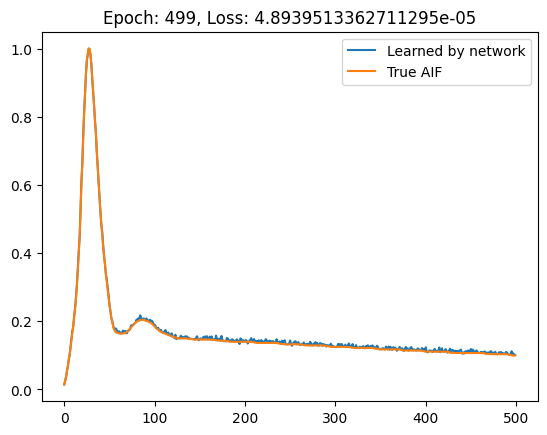

In [31]:
def train_fcnn_agv_AIF(in_AIF, model, optimizer):
  loss_fn_2 = nn.MSELoss()

  iters, train_loss_history = [], []
  model.train()

  epochs = 500
  n = 0

  # Get the correct size for the AIF

  # Determine the shape of AIF based on the target in the data loader
  for _, z in train_loader:
      z = torch.flatten(z, start_dim=1, end_dim=-1)
      z = z.to(device)
      z = z.float()
      AIF_shape = z[:, 2:].T.shape
      break

  # Initialize and replicate the input AIF tensor across all samples
  AIF = torch.tensor(in_AIF, device=device, dtype=torch.float32).repeat(AIF_shape[1], 1)

  for epoch in range(epochs):
      for x, z in train_loader:
          x = torch.flatten(x, start_dim=1, end_dim=-1)

          x = x.to(device)

          x = x.float()

          optimizer.zero_grad()
          out = model(x)

          loss = loss_fn_2(out, AIF)
          loss.backward()
          optimizer.step()

          train_loss_history.append(loss.item())
          iters.append(n)


          n += 1
      if epoch%1==0:


          test = out.cpu().detach().numpy()
          test = test / test.max(axis=1, keepdims=True)
          ax.cla()
          ax.plot(test[0,:].T, label = "Learned by network")
          ax.plot(in_AIF.T, label = "True AIF")
          ttl = "Epoch: " + str(epoch) + ", Loss: " + str(loss.item())
          ax.set_title(ttl)
          ax.legend()
          display(fig)

          clear_output(wait = True)
          plt.pause(0.01)


  return train_loss_history, iters

import scipy.io
mat_data = scipy.io.loadmat('AIF.mat')

data = mat_data['AIF']
avg_AIF = np.array(data)

AIF_model = FCNN([2000,1500,700,500])
AIF_model.to(device)
AIF_optimizer = optim.Adam(AIF_model.parameters(), 0.0001)
train_loss_history, iters = train_fcnn_agv_AIF(avg_AIF, AIF_model, AIF_optimizer)

### Function: `evaluate_fcnn_avg_AIF`
This function evaluates a fully connected neural network (FCNN) using an average Arterial Input Function (AIF) as the target, and calculates the mean and variance of the percentage errors.

- **Parameters:**
  - `model` (nn.Module): The FCNN model to be evaluated.
  - `in_AIF` (numpy array): The average AIF used as the target during evaluation.

- **Returns:**
  - `mean_err_AIF` (list): A list of mean percentage errors for each batch in the evaluation dataset.
  - `var_err_AIF` (list): A list of variance of percentage errors for each batch in the evaluation dataset.

- **Evaluation Process:**
  - The function begins by determining the shape of the AIF tensor required for evaluation, based on the target data in `train_loader`.
  - The provided AIF (`in_AIF`) is converted to a tensor and replicated to match the batch size.
  - The model is evaluated in inference mode, where it computes outputs without updating weights.
  - The mean and variance of the percentage errors between the model's output and the fixed AIF are calculated and stored.

- **Usage:**
  - The function is called after initializing the model and loading the average AIF.
  - It returns the mean and variance of the percentage errors for further analysis or averaging across all batches.

In [32]:
def evaluate_fcnn_avg_AIF(model, in_AIF):
    loss_fn = PercentageErrorStats()
    mean_err_AIF = []
    var_err_AIF = []

    torch.set_printoptions(precision=3)

    with torch.no_grad():
        model.eval()

        for x, z in train_loader:
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            z = z.to(device)

            z = z.float()
            temp = z.cpu().detach().numpy()
            temp = temp[:,2:].T
            AIF_shape = temp.shape
            break
        AIF = torch.zeros(AIF_shape, device=device)
        in_AIF_tensor = torch.tensor(in_AIF, device=device, dtype=AIF.dtype)
        for n in range(AIF_shape[1]):
            AIF[:,n] = in_AIF_tensor

        AIF = AIF.float()
        AIF = AIF.T
        for x, z in train_loader:
            x = torch.flatten(x, start_dim=1, end_dim=-1)

            x = x.to(device)

            x = x.float()


            out = model(x)


            loss_mean, loss_var = loss_fn(out, AIF)
            mean_err_AIF.append(loss_mean.item())
            var_err_AIF.append(loss_var.item())
    return mean_err_AIF, var_err_AIF

mean_err_AIF, var_err_AIF = evaluate_fcnn_avg_AIF(AIF_model, avg_AIF)
print(np.mean(mean_err_AIF))
print(np.mean(var_err_AIF))

3.5132626908166067
1.9253664425441197


### Class: `CustomLoss`
This class implements a custom loss function designed to compare the model's output with the target concentration data.

- **Initialization (`__init__`):**
  - The class is initialized without any specific parameters.

- **Forward Pass (`forward`):**
  - **Parameters:**
    - `output` (tensor): The model's predicted outputs, containing both PK parameters and the AIF.
    - `inp` (tensor): The input data, which includes the target concentration.
  - **Returns:**
    - `loss` (tensor): The computed loss value.
  - **Functionality:**
    - The function extracts the concentration data and AIF from the input and output tensors.
    - It then pads the AIF and performs a Fourier transform to simulate the concentration.
    - The loss is computed as the mean squared error (MSE) between the simulated concentration and the target concentration, with an additional L2 Total Variation (L2TV) regularization term.

### Function: `train_fcnn_multi`
This function trains two fully connected neural networks (FCNNs) simultaneously—one for predicting pharmacokinetic (PK) parameters and another for predicting the Arterial Input Function (AIF).

- **Parameters:**
  - `PK_model` (nn.Module): The FCNN model for predicting PK parameters.
  - `AIF_model` (nn.Module): The FCNN model for predicting the AIF.
  - `PK_optimizer` (torch.optim.Optimizer): The optimizer used for updating the PK model's weights.
  - `AIF_optimizer` (torch.optim.Optimizer): The optimizer used for updating the AIF model's weights.

- **Returns:**
  - `train_loss_history` (list): A list of loss values recorded during training.
  - `iters` (list): A list of iteration counts corresponding to each recorded loss value.

- **Training Process:**
  - The function trains both models for 1000 epochs, iterating over the training data provided by `train_loader`.
  - Inputs `x` and targets `z` are flattened and moved to the appropriate device.
  - The models' outputs are concatenated and passed to the custom loss function, which compares them against the input data.
  - The loss is backpropagated, and the optimizers update the weights of both models.
  - After each epoch, the learned AIF is plotted against the true AIF to visualize the model's progress.

- **Usage:**
  - The function is called after initializing both models, their optimizers, and the plotting environment.
  - It returns the training loss history and the iteration numbers for further analysis or plotting.

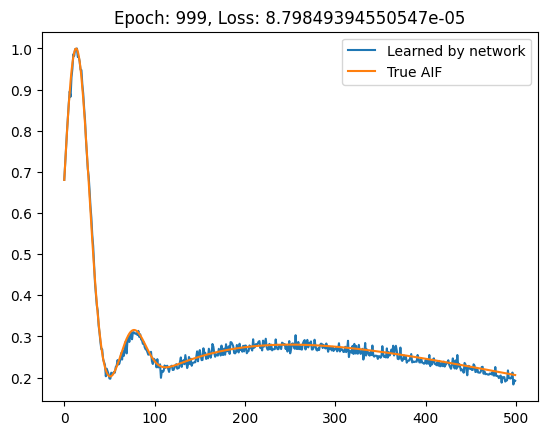

In [33]:
from operator import truth
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, inp):
        conc = inp[:,0:500]


        inparams = output[:,0:2]
        dim = output.shape[0]
        AIF = output[:,2:]
        AIF = AIF.T
        conc = conc.T
        kt = torch.ones(dim,)

        kep = output[:,0]
        vp = output[:,1]
        t = torch.linspace(0,120, 500)
        t /= 60
        t = t.to(device)
        kt = kt.to(device)

        AIFpad =  torch.zeros(1024,dim)
        AIFpad = AIFpad.to(device)
        AIFpad[0:500,:] = AIF
        hpad = torch.zeros(AIFpad.shape)
        hpad = hpad.to(device)
        del_t = t[2]-t[1]

        for n in range(dim):
            h = torch.exp(-kep[n]*t)*kt[n]*del_t
            h[0] += vp[n]
            hpad[0:500,n] = h.reshape(-1,)

        x = torch.abs(torch.fft.ifft(torch.fft.fft(AIFpad, dim=0)*torch.fft.fft(hpad, dim=0), dim=0))
        x = x[0:500,:]

        x = x/torch.mean(x,0)
        conc = conc/torch.mean(conc,0)

        var = x[1:,:] - x[:-1,:]
        L2TV = torch.norm(var, p=2)

        loss = torch.mean((x.flatten() - conc.flatten())**2)
        return loss

def train_fcnn_multi(PK_model, AIF_model, PK_optimizer, AIF_optimizer):
    loss_fn = CustomLoss()

    iters, train_loss_history = [], []
    AIF_model.train()
    PK_model.train()

    epochs = 1000
    n = 0

    for epoch in range(epochs):
        for x, z in train_loader:
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            x = x.to(device)
            z = z.to(device)

            x = x.float()
            z = z.float()

            PK_optimizer.zero_grad()
            AIF_optimizer.zero_grad()

            AIF_out = AIF_model(x)
            PK_out = PK_model(x)

            loss = loss_fn(torch.cat((PK_out, AIF_out),1), x)

            loss.backward()
            PK_optimizer.step()
            AIF_optimizer.step()
            PK_optimizer.zero_grad()
            AIF_optimizer.zero_grad()


            train_loss_history.append(loss.item())
            iters.append(n)


            n += 1
        if epoch%1 == 0:

            test = AIF_out.cpu().detach().numpy()
            test = test / test.max(axis=1, keepdims=True)
            truth = z.cpu().detach().numpy()
            truth = truth / truth.max(axis=1, keepdims=True)
            ax.cla()
            ax.plot(test[0,:].T, label = "Learned by network")
            ax.plot(truth[0,2:], label = "True AIF")
            ttl = "Epoch: " + str(epoch) + ", Loss: " + str(loss.item())
            ax.set_title(ttl)
            ax.legend()
            display(fig)

            clear_output(wait = True)
            plt.pause(0.01)
    return train_loss_history, iters

PK_model = FCNN([2000,500,50,2])
PK_model.to(device)
PK_optimizer = optim.Adam(PK_model.parameters(), 0.0001)
AIF_optimizer = optim.Adam(AIF_model.parameters(), 0.000005)
train_loss_history, iters = train_fcnn_multi(PK_model, AIF_model, PK_optimizer, AIF_optimizer)

### Function: `evaluate_fcnn_multi`
This function evaluates two fully connected neural networks (FCNNs)—one for predicting the Arterial Input Function (AIF) and another for predicting pharmacokinetic (PK) parameters—by calculating the mean and variance of percentage errors for both outputs.

- **Parameters:**
  - `AIF_model` (nn.Module): The FCNN model for predicting the AIF.
  - `PK_model` (nn.Module): The FCNN model for predicting the PK parameters.

- **Returns:**
  - `mean_err_AIF` (list): A list of mean percentage errors for the AIF predictions across all batches in the evaluation dataset.
  - `var_err_AIF` (list): A list of variance of percentage errors for the AIF predictions.
  - `mean_err_PK` (list): A list of mean percentage errors for the PK parameter predictions.
  - `var_err_PK` (list): A list of variance of percentage errors for the PK parameter predictions.

- **Evaluation Process:**
  - The function evaluates both models in inference mode (with `torch.no_grad()` to prevent gradient computation).
  - Inputs `x` and targets `z` are flattened and moved to the appropriate device.
  - The outputs of both models are normalized and compared against the corresponding ground truth values using the `PercentageErrorStats` loss function.
  - The mean and variance of the percentage errors for both the AIF and PK parameters are calculated and stored.

- **Usage:**
  - The function is called after training the models and is used to evaluate their performance on the test dataset.
  - The function returns the mean and variance of the percentage errors for further analysis or averaging across all batches.

In [34]:
def evaluate_fcnn_multi(AIF_model, PK_model):
    loss_fn = PercentageErrorStats()
    mean_err_AIF = []
    var_err_AIF = []
    mean_err_PK = []
    var_err_PK = []

    torch.set_printoptions(precision=3)

    with torch.no_grad():
        AIF_model.eval()
        PK_model.eval()

        for x, z in train_loader:
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            x = x.to(device)
            z = z.to(device)

            x = x.float()
            z = z.float()


            AIF_out = AIF_model(x)
            PK_out = PK_model(x)

            test = AIF_out
            test = test / test.max(axis=1, keepdims=True).values
            truth = z[:,2:]
            truth = truth / truth.max(axis=1, keepdims=True).values

            loss_mean, loss_var = loss_fn(test, truth)
            mean_err_AIF.append(loss_mean.item())
            var_err_AIF.append(loss_var.item())

            test = PK_out
            test = test / test[:,0:1]
            truth = z[:,0:2]
            truth = truth / truth[:,0:1]

            test = test[1,:]
            truth = truth[1,:]

            loss_mean, loss_var = loss_fn(test, truth)
            mean_err_PK.append(loss_mean.item())
            var_err_PK.append(loss_var.item())
    return mean_err_AIF, var_err_AIF, mean_err_PK, var_err_PK

mean_err_AIF, var_err_AIF, mean_err_PK, var_err_PK = evaluate_fcnn_multi(AIF_model, PK_model)
print(np.mean(mean_err_AIF))
print(np.mean(var_err_AIF))
print(np.mean(mean_err_PK))
print(np.mean(var_err_PK))




4.373967456817627
2.7519229786736625
26.322879852141654
37.226173483899665


### Dataset Preparation

- **`gen_batch(500,1)` and `gen_batch(100,3)`**:
  - Two datasets are generated using the `gen_batch` function:
    - `y_matrix_target`, `x_matrix_target`: Target dataset with 500 samples, each containing one batch of data.
    - `y_matrix_swap`, `x_matrix_swap`: Swap dataset with 100 samples, each containing three batches of data.

### Class: `TrainDceDatasetSwap`
This class defines a custom dataset for training using the swap dataset.

- **Initialization (`__init__`):**
  - Initializes the dataset with the swap data (`x_matrix_swap`, `y_matrix_swap`).

- **`__len__` Method:**
  - Returns the number of samples in the dataset.

- **`__getitem__` Method:**
  - Returns the `index`-th sample as a tuple `(x, y)` where `x` and `y` correspond to the input and target data, respectively.

### Class: `TrainDceDatasetTarget`
This class defines a custom dataset for training using the target dataset.

- **Initialization (`__init__`):**
  - Initializes the dataset with the target data (`x_matrix_target`, `y_matrix_target`).

- **`__len__` Method:**
  - Returns the number of samples in the dataset.

- **`__getitem__` Method:**
  - Returns the `index`-th sample as a tuple `(x, y)` where `x` and `y` correspond to the input and target data, respectively.

### DataLoader Creation

- **`train_dce_dataset_target` and `train_dce_dataset_swap`**:
  - Instances of `TrainDceDatasetTarget` and `TrainDceDatasetSwap` are created.
  
- **`train_loader_target` and `train_loader_swap`**:
  - DataLoader objects are created for each dataset to shuffle and batch the data during training.

### Function: `train_fcnn_multi_swap_mean`
This function trains two fully connected neural networks (FCNNs) simultaneously—one for predicting pharmacokinetic (PK) parameters and another for predicting the Arterial Input Function (AIF)—using both the target and swap datasets.

- **Parameters:**
  - `PK_model` (nn.Module): The FCNN model for predicting PK parameters.
  - `AIF_model` (nn.Module): The FCNN model for predicting the AIF.
  - `PK_optimizer` (torch.optim.Optimizer): The optimizer used for updating the PK model's weights.
  - `AIF_optimizer` (torch.optim.Optimizer): The optimizer used for updating the AIF model's weights.

- **Returns:**
  - `train_loss_history` (list): A list of loss values recorded during training.
  - `iters` (list): A list of iteration counts corresponding to each recorded loss value.

- **Training Process:**
  - The function trains both models for 200 epochs, iterating over the target dataset.
  - During each iteration, the swap dataset is also used to augment the training data by concatenating the inputs.
  - The concatenated data is fed to both models, and the loss is accumulated over the swap dataset before being backpropagated.
  - After each epoch, the learned AIF is plotted against the true AIF to visualize the model's progress.

- **Usage:**
  - The function is called after initializing both models, their optimizers, and the DataLoaders.
  - It returns the training loss history and the iteration numbers for further analysis or plotting.

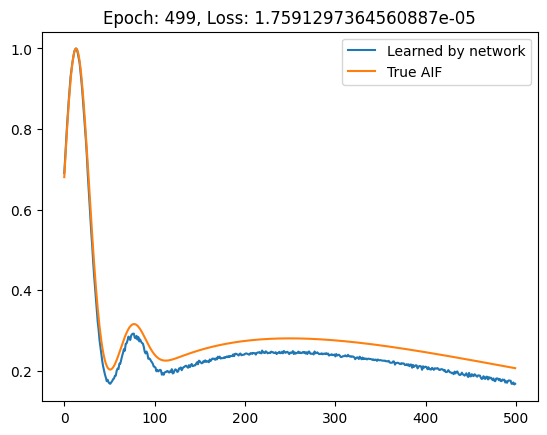

In [38]:
# First, make two new datasets. One to be the target, and one to be the set that is swapped out
y_matrix_target, x_matrix_target = gen_batch(500,1)
y_matrix_swap, x_matrix_swap = gen_batch(100,3)

# Dataset class for the training portion of data
class TrainDceDatasetSwap(Dataset):
    def __init__(self):
        self.x = x_matrix_swap
        self.y = y_matrix_swap

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        # returns ith sample as a tuple (x, z), where x is [4x500], and z is [4x2]
        return self.x[index], self.y[index]

class TrainDceDatasetTarget(Dataset):
    def __init__(self):
        self.x = x_matrix_target
        self.y = y_matrix_target

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        # returns ith sample as a tuple (x, z), where x is [4x500], and z is [4x2]
        return self.x[index], self.y[index]


# convert data sourced from path into a dataset; and perform any transforms from torchvision as needed...
train_dce_dataset_target = TrainDceDatasetTarget()
train_dce_dataset_swap = TrainDceDatasetSwap()



# define the dataloader needed for shuffling/sampling batches to train on
train_loader_target = torch.utils.data.DataLoader(train_dce_dataset_target, batch_size=5) # !!! use default sampler for now !!!
train_loader_swap = torch.utils.data.DataLoader(train_dce_dataset_swap, batch_size=5) # !!! use default sampler for now !!!


def train_fcnn_multi_swap_mean(PK_model, AIF_model, PK_optimizer, AIF_optimizer):
    loss_fn = CustomLoss()

    iters, train_loss_history = [], []
    AIF_model.train()
    PK_model.train()

    epochs = 500
    n = 0

    for epoch in range(epochs):
        for x, z in train_loader_target:
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            x = x.to(device)
            z = z.to(device)

            x = x.float()
            z = z.float()

            PK_optimizer.zero_grad()
            AIF_optimizer.zero_grad()

            loss = 0
            AIF_out = 0
            PK_out = 0
            n = 0


            for x_swap, z_swap in train_loader_swap:
                x_swap = torch.flatten(x_swap, start_dim=1, end_dim=-1)
                z_swap = torch.flatten(z_swap, start_dim=1, end_dim=-1)

                x_swap = x_swap.to(device)
                z_swap = z_swap.to(device)

                x_swap = x_swap.float()
                z_swap = z_swap.float()

                x_input = torch.cat((x, x_swap), dim=1)
                AIF_out += AIF_model(x_input)
                PK_out += PK_model(x_input)
                n += 1
            AIF_out /= n
            PK_out /= n
            loss = loss_fn(torch.cat((PK_out, AIF_out),1), x_input)

            loss.backward()
            PK_optimizer.step()
            AIF_optimizer.step()
            PK_optimizer.zero_grad()
            AIF_optimizer.zero_grad()


            train_loss_history.append(loss.item())
            iters.append(n)

        if epoch%1 == 0:
            test = AIF_out.cpu().detach().numpy()
            test = test / test.max(axis=1, keepdims=True)
            truth = z.cpu().detach().numpy()
            truth = truth / truth.max(axis=1, keepdims=True)
            ax.cla()
            ax.plot(test[0,:].T, label = "Learned by network")
            ax.plot(truth[0,2:], label = "True AIF")
            ttl = "Epoch: " + str(epoch) + ", Loss: " + str(loss.item())
            ax.set_title(ttl)
            ax.legend()
            display(fig)

            clear_output(wait = True)
            plt.pause(0.01)
    return train_loss_history, iters

# AIF_optimizer = optim.Adam(AIF_model.parameters(), 0.005)
# PK_optimizer = optim.Adam(PK_model.parameters(), 0.005)
train_loss_history, iters = train_fcnn_multi_swap_mean(PK_model, AIF_model, PK_optimizer, AIF_optimizer)

### Function: `evaluate_fcnn_multi`
This function evaluates two fully connected neural networks (FCNNs)—one for predicting the Arterial Input Function (AIF) and another for predicting pharmacokinetic (PK) parameters—by calculating the mean and variance of percentage errors for both outputs.

- **Parameters:**
  - `AIF_model` (nn.Module): The FCNN model for predicting the AIF.
  - `PK_model` (nn.Module): The FCNN model for predicting the PK parameters.

- **Returns:**
  - `mean_err_AIF` (list): A list of mean percentage errors for the AIF predictions across all batches in the evaluation dataset.
  - `var_err_AIF` (list): A list of variance of percentage errors for the AIF predictions.
  - `mean_err_PK` (list): A list of mean percentage errors for the PK parameter predictions.
  - `var_err_PK` (list): A list of variance of percentage errors for the PK parameter predictions.

- **Evaluation Process:**
  - The function evaluates both models in inference mode using `torch.no_grad()` to prevent gradient computation.
  - Inputs `x` and targets `z` are flattened and moved to the appropriate device.
  - The outputs of both models are normalized and compared against the corresponding ground truth values using the `PercentageErrorStats` loss function.
  - The mean and variance of the percentage errors for both the AIF and PK parameters are calculated and stored.

- **Usage:**
  - The function is called after training the models and is used to evaluate their performance on the test dataset.
  - The function returns the mean and variance of the percentage errors for further analysis or averaging across all batches.

In [ ]:
def evaluate_fcnn_multi(AIF_model, PK_model):
    loss_fn = PercentageErrorStats()
    mean_err_AIF = []
    var_err_AIF = []
    mean_err_PK = []
    var_err_PK = []

    torch.set_printoptions(precision=3)

    with torch.no_grad():
        AIF_model.eval()
        PK_model.eval()


        for x, z in train_loader_target:
            x = torch.flatten(x, start_dim=1, end_dim=-1)
            z = torch.flatten(z, start_dim=1, end_dim=-1)

            x = x.to(device)
            z = z.to(device)

            x = x.float()
            z = z.float()

            PK_optimizer.zero_grad()
            AIF_optimizer.zero_grad()

            loss = 0


            for x_swap, z_swap in train_loader_swap:
                x_swap = torch.flatten(x_swap, start_dim=1, end_dim=-1)
                z_swap = torch.flatten(z_swap, start_dim=1, end_dim=-1)

                x_swap = x_swap.to(device)
                z_swap = z_swap.to(device)

                x_swap = x_swap.float()
                z_swap = z_swap.float()

                x_input = torch.cat((x, x_swap), dim=1)

                AIF_out = AIF_model(x_input)
                PK_out = PK_model(x_input)

                test = AIF_out
                test = test / test.max(axis=1, keepdims=True).values
                truth = z[:,2:]
                truth = truth / truth.max(axis=1, keepdims=True).values


                loss_mean, loss_var = loss_fn(test, truth)
                mean_err_AIF.append(loss_mean.item())
                var_err_AIF.append(loss_var.item())

                test = PK_out
                test = test / test[:,0:1]
                truth = z[:,0:2]
                truth = truth / truth[:,0:1]

                test = test[1,:]
                truth = truth[1,:]

                loss_mean, loss_var = loss_fn(test, truth)
                mean_err_PK.append(loss_mean.item())
                var_err_PK.append(loss_var.item())


    return mean_err_AIF, var_err_AIF, mean_err_PK, var_err_PK

mean_err_AIF, var_err_AIF, mean_err_PK, var_err_PK = evaluate_fcnn_multi(AIF_model, PK_model)
print(np.mean(mean_err_AIF))
print(np.mean(var_err_AIF))
print(np.mean(mean_err_PK))
print(np.mean(var_err_PK))


In [ ]:
print(mean_err_PK)
